In [1]:
import pandas as pd
import numpy as np
from binance.client import Client
from datetime import date, datetime, timedelta, UTC

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import backtrader as bt

from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error

In [2]:
client = Client()

In [3]:
def get_binance_data(symbol='BTCUSDT', interval='5m', lookback = '60 days'):
    now = datetime.now(UTC)
    past = now - pd.to_timedelta(lookback)

    df = pd.DataFrame(client.get_historical_klines(symbol, interval, str(past), str(now)
    ), columns=['open_time','Open', 'High', 'Low', 'Close', 'Volume', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol','is_best_match'])
    
    df['Date']= pd.to_datetime(df['close_time'], unit='ms')
    return df[['Date','Open', 'High', 'Low', 'Close', 'Volume']]  

In [4]:
%%time
data = get_binance_data(interval='5m')

CPU times: user 141 ms, sys: 25 ms, total: 166 ms
Wall time: 12.2 s


In [5]:
data.tail()

,Date,Open,High,Low,Close,Volume
17275,2025-06-27 12:24:59.999,106986.56000000,107200.00000000,106986.55000000,107160.90000000,37.76204000
17276,2025-06-27 12:29:59.999,107160.90000000,107183.23000000,107160.90000000,107176.42000000,17.17716000
17277,2025-06-27 12:34:59.999,107176.41000000,107176.42000000,106777.01000000,106989.34000000,174.87497000
17278,2025-06-27 12:39:59.999,106989.33000000,107020.00000000,106859.10000000,106859.11000000,53.59987000
17279,2025-06-27 12:44:59.999,106859.11000000,106888.01000000,106735.60000000,106756.03000000,39.55588000


In [6]:
data.to_csv('Data_set_for_analitics_5min.csv')

In [7]:
# Forecasting
df_train = data[['Date', 'Close']]
df_train = df_train.astype({'Close':'float'})
df_train = df_train.rename(columns={"Date": "ds", 'Close': "y"})
df_test = df_train.iloc[-288:]

In [8]:
## Creating model parameters
model_param ={
    "n_changepoints": 100, # fewer changepoints speed up predictions
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": False,
    "seasonality_mode": "multiplicative",
    "changepoint_prior_scale": 0.1,
    "seasonality_prior_scale": 10.0,
    "holidays_prior_scale": 10.0,
    "growth": "logistic" #or linear.Then will need to delete cap paremeter/linear is by default
}
m = Prophet(**model_param)  #**model_param
df_train['cap']= df_train["y"].max() + df_train["y"].std() * 0.05
m.add_country_holidays(country_name='US')
m.add_seasonality(name='dayly', period=1, fourier_order=10)
m.add_seasonality(name='weekly', period=7, fourier_order=6)
m.add_seasonality(name='hourly', period=1/24, fourier_order=5)

In [9]:
m.fit(df_train.iloc[-15000:]) # Train on the training set

15:45:22 - cmdstanpy - INFO - Chain [1] start processing
15:46:07 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
with open('serialized_model_Prophet_5min.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model#save the model if needed with serialization

In [15]:
with open('serialized_model_Prophet_5min.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model #load the model if needed

In [33]:
future = m.make_future_dataframe(periods=288, freq='5min') #5 minutes
future['cap'] = df_train['cap'].max()
#forecast = m.predict(future, parallel="threads")
forecast = m.predict(future)

In [34]:
mae = mean_absolute_error(df_train['y'].iloc[-15000:], forecast['yhat'].iloc[:-288])

In [35]:
result = forecast.merge(
    data[['Date', 'Close']], 
    left_on='ds',         
    right_on='Date',       
    how='left'               
)

In [36]:
result.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,...,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,Date,Close
15283,2025-06-28 12:24:59.999,104889.067368,112139.996801,102446.900347,104992.350526,104526.637025,105208.633797,0.0,0.0,0.0,...,-0.010595,-0.010779,-0.010779,-0.010779,0.0,0.0,0.0,103777.776300,NaT,NaN
15284,2025-06-28 12:29:59.999,104889.149252,112139.996801,102438.906572,105137.233170,104524.591947,105210.535121,0.0,0.0,0.0,...,-0.010638,-0.010762,-0.010762,-0.010762,0.0,0.0,0.0,103773.314926,NaT,NaN
15285,2025-06-28 12:34:59.999,104889.231134,112139.996801,102333.520515,105052.272654,104522.776258,105212.439391,0.0,0.0,0.0,...,-0.010638,-0.010745,-0.010745,-0.010745,0.0,0.0,0.0,103773.451130,NaT,NaN
15286,2025-06-28 12:39:59.999,104889.313015,112139.996801,102476.125354,105111.464815,104520.986514,105215.178186,0.0,0.0,0.0,...,-0.010596,-0.010728,-0.010728,-0.010728,0.0,0.0,0.0,103777.856552,NaT,NaN
15287,2025-06-28 12:44:59.999,104889.394896,112139.996801,102429.129010,105028.542682,104519.181009,105216.533251,0.0,0.0,0.0,...,-0.010645,-0.010712,-0.010712,-0.010712,0.0,0.0,0.0,103772.871226,NaT,NaN


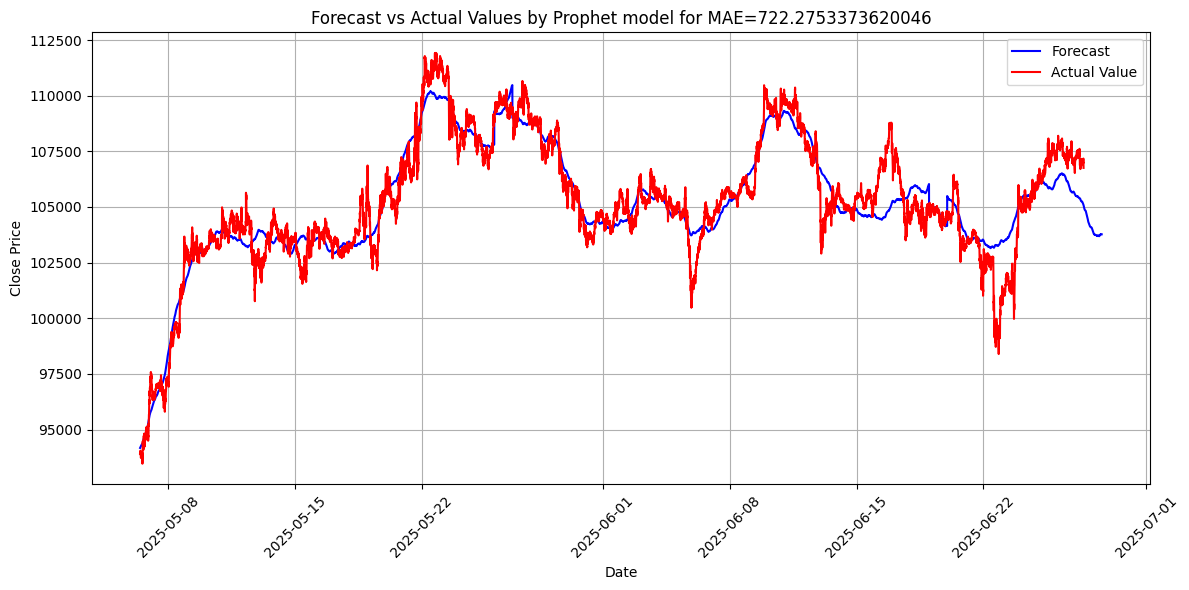

In [37]:
plt.figure(figsize=(12, 6))
result['Close'] = pd.to_numeric(result['Close'])
plt.plot(result['ds'], result['yhat'], 'b-', label='Forecast')
plt.plot(result['ds'], result['Close'], 'r-', label='Actual Value')  # Changed label to string
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Close Price')
plt.title(f'Forecast vs Actual Values by Prophet model for MAE={mae}')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent label cutoff
plt.show()

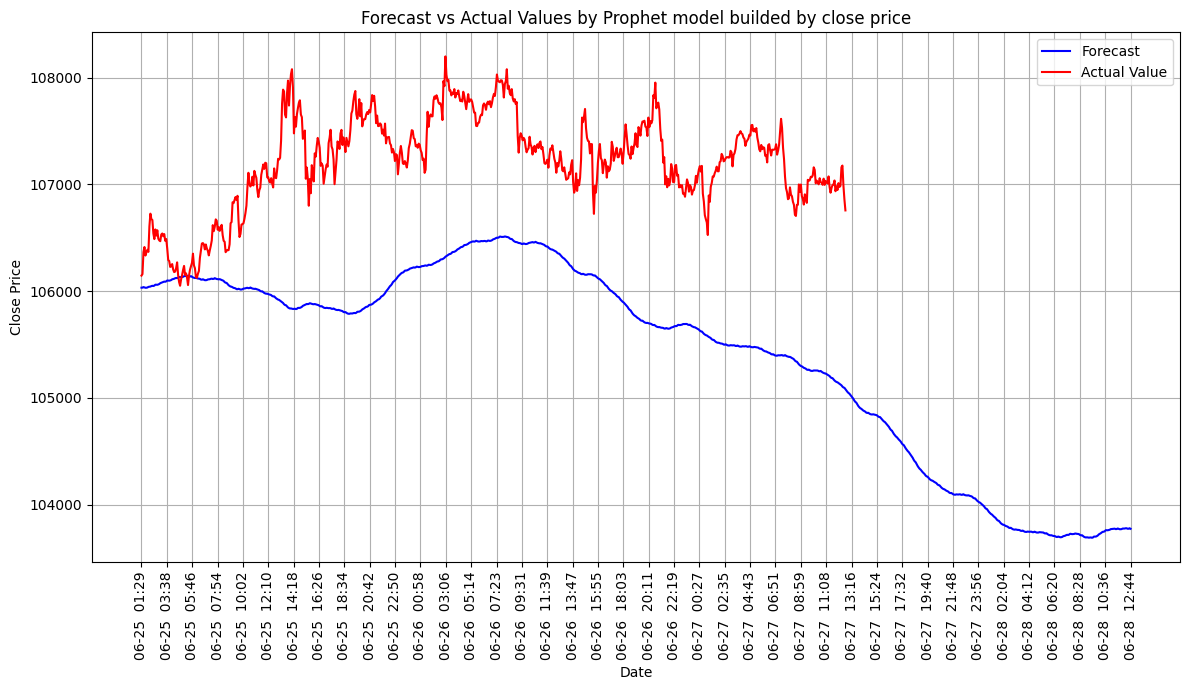

In [38]:
amount_of_5min = 1000
plt.figure(figsize=(12, 7))
result['Close'] = pd.to_numeric(result['Close'])
plt.plot(result['ds'].iloc[-amount_of_5min:], result['yhat'].iloc[-amount_of_5min:], 'b-', label='Forecast')
plt.plot(result['ds'].iloc[-amount_of_5min:], result['Close'].iloc[-amount_of_5min:], 'r-', label='Actual Value')  # Changed label to string
plt.xlabel('Date')

tick_dates= pd.date_range(start = result['ds'].iloc[-amount_of_5min:].min(), 
                          end = result['ds'].iloc[-amount_of_5min:].max(), 
                          periods = 40)
plt.xticks(tick_dates, rotation=90)
ax = plt.gca()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d  %H:%M'))

plt.ylabel('Close Price')
plt.title('Forecast vs Actual Values by Prophet model builded by close price')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent label cutoff
plt.show()

In [19]:
# Save the plot with date and time in the filename
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
plt.savefig(f'moving_average_crossover_strategy_{timestamp}.png')  # Save with timestamp

<Figure size 640x480 with 0 Axes>

# Plotting partst of the forecast:
-Actual data points (black dots)

-Forecast line (yhat)

-Uncertainty bands (yhat_lower, yhat_upper)

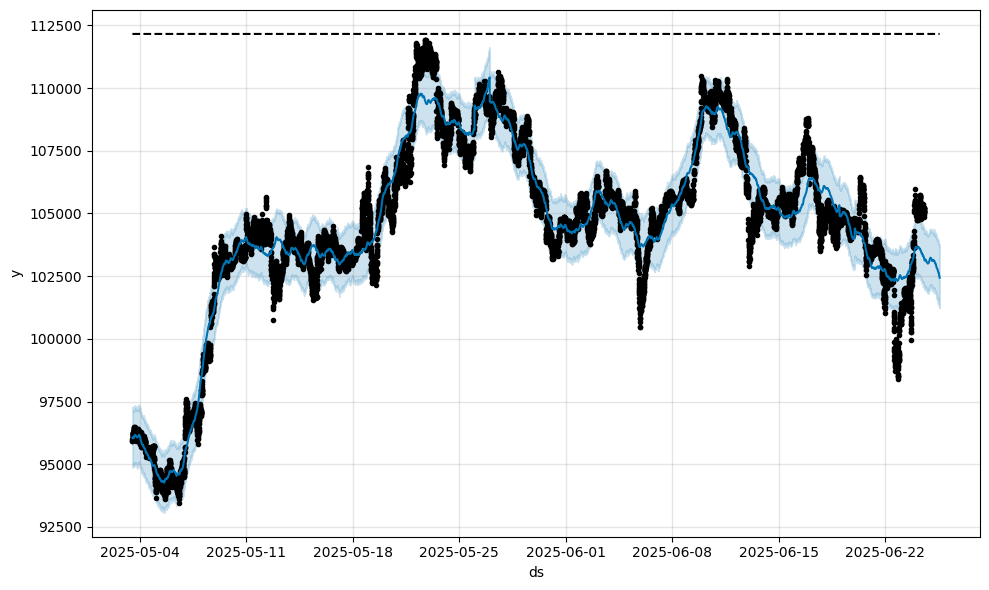

In [57]:
fig1 = m.plot(forecast)
#a = add_changepoints_to_plot(fig1.gca(), m, forecast)
plt.show()

# Visualizes individual model components:

-Trend

-Weekly seasonality

-Yearly seasonality

-Holidays (if added)

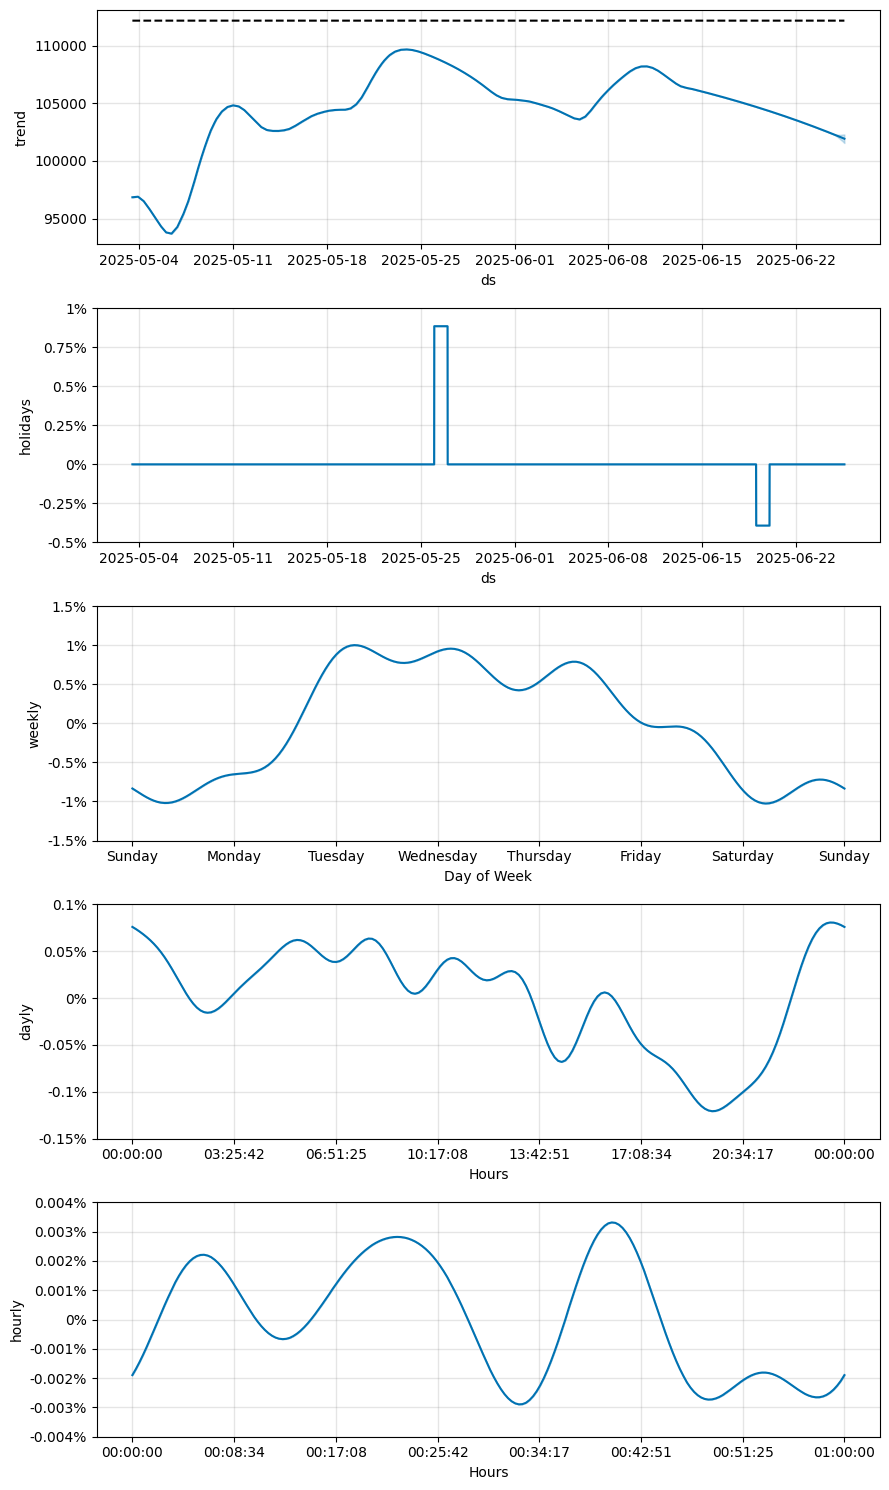

In [25]:
fig2 = m.plot_components(forecast)
plt.show()

In [29]:
result[['ds','yhat','Close','Date']].to_csv('forecast_course.csv' )

In [ ]:
#fig3 = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()